In [1]:
import sys
from pathlib import Path

import gensim
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

CWD = Path('.').absolute()
sys.path.insert(0, str(CWD / 'python' / 'pysommy'))
from pysommy.sommy import BatchGenerator, Som, GaussianNeighbourhood, SomTrainer

### Data

In [ ]:
MODEL_PATH = CWD / 'glove.6B.50d.w2v.txt'
glove = gensim.models.KeyedVectors.load_word2vec_format(str(MODEL_PATH))

In [ ]:
profs = """
accountant,teacher,physician,engineer,technician,lawyer,labourer,pharmacist,psychologist,veterinarian,midwife,surveyor,mechanic,dietitian,electrician,surgeon,radiographer,
caregiver,programmer,hygienist,plumber,dentist,architect,actuary,judge,actor,technologist,butcher,secretary,musician,coiffeur,designer,firefighter,chef,psychiatrist,
policeman,consultant,paramedic,welder,artist,statistician,broker,chiropractor,machinist,pilot,nutritionist,landscaper,librarian,optician,salesperson
""".replace('\n', '').split(',')
profs = list(set(p for p in profs if p in glove))
profs_sim = {prof: list(set(p for p, _ in glove.most_similar(prof, topn=10))) for prof in profs}

In [2]:
#words = list(set(p for prof in profs for p in [prof] + profs_sim[prof]))
#vectors = np.asarray([glove[w] for w in words])#
#np.save(CWD / 'vectors', arr=vectors)
#open(CWD / 'words.txt', 'w').writelines([w + '\n' for w in words])

In [ ]:
vectors = np.load(CWD / 'vectors.npy')
vectors_norms = (vectors * vectors).sum(axis=1) ** 0.5
vectors = vectors / vectors_norms[:, np.newaxis]

### Model

In [3]:
som = Som(height=64, width=64, depth=vectors.shape[1])
batch_gen = BatchGenerator(data=vectors, batch_size=8, shuffle=True)

In [21]:
max_epochs = 512
max_iters = len(batch_gen) * max_epochs
sigma_init = max(som.width, som.height) / 2
sigma_decay = lambda t: sigma_init * np.exp(- t * np.log(sigma_init) / max_iters)
lr_init = 0.1
lr_decay = lambda t: lr_init * np.exp(- t / max_iters)

In [22]:
#sb.set()
#sb.set_style('darkrid')
#iters = np.arange(max_iters)
#pd.Series(index=iters, data=map(lr_decay, iters)).plot(figsize=(10, 6), title='Learning rate')
#plt.show()
#pd.Series(index=iters, data=map(sigma_decay, iters)).plot(figsize=(10, 6), title='Sigma')
#plt.show()

In [23]:
gaussian = GaussianNeighbourhood(som=som, sigma_decay=sigma_decay)
trainer = SomTrainer(som=som, neighbourhood=gaussian, lr_decay=lr_decay)

In [ ]:
trainer.fit(batch_gen=batch_gen, epochs=max_epochs, progress_bar=tqdm_notebook)

HBox(children=(IntProgress(value=0, max=512), HTML(value='')))

### Results

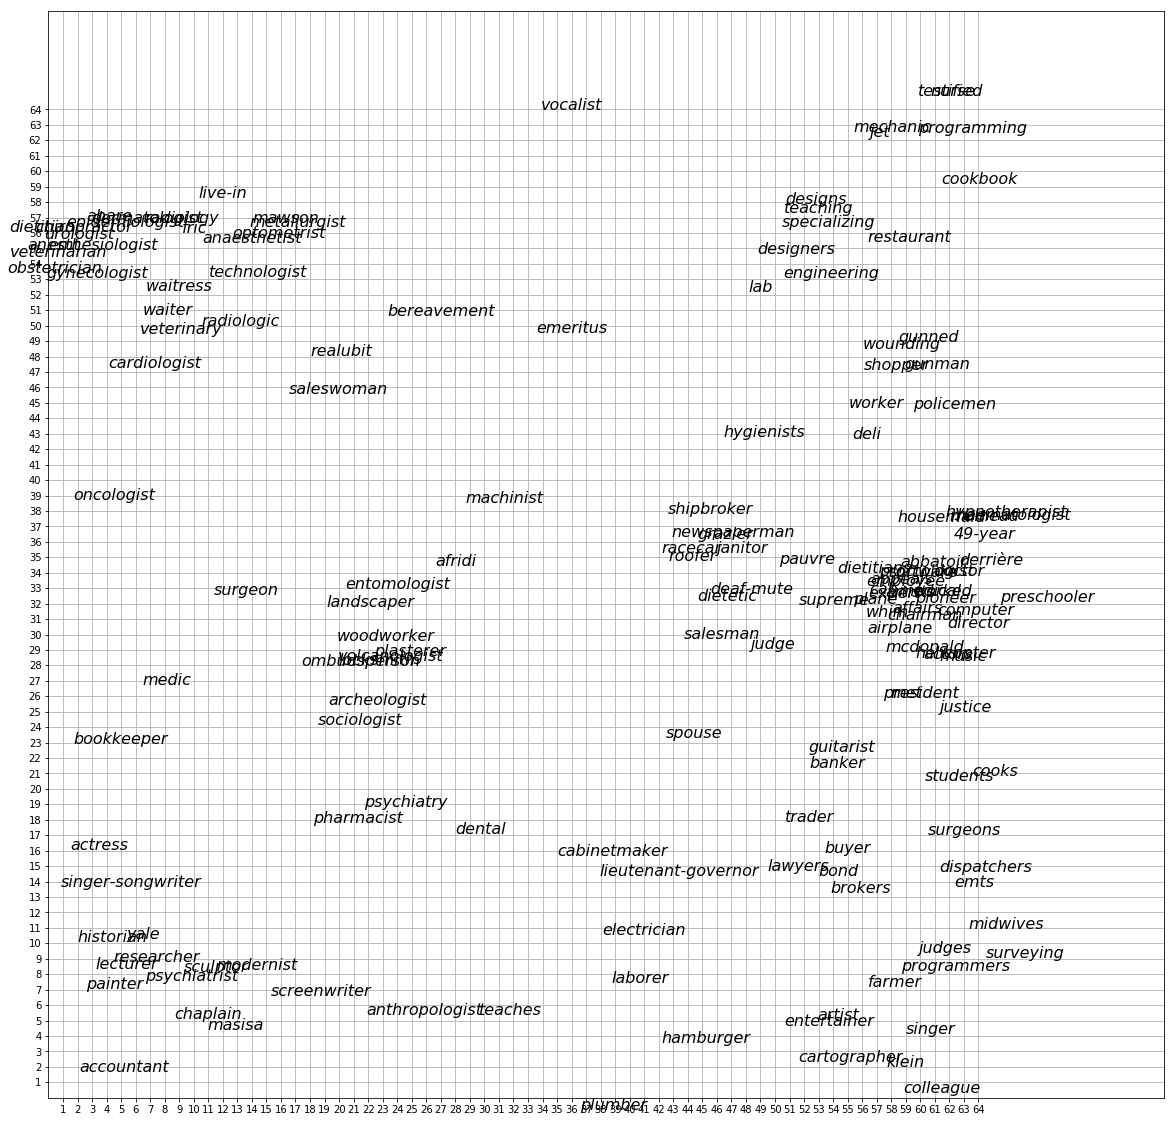

In [20]:
plt.figure(figsize=(20, 20))
colors = ['red', 'green', 'blue', 'magenta', 'black']
words = []
for i, prof in enumerate(profs[:64]):
    c = colors[i % len(colors)]
    c = 'black'
    for sim in profs_sim[prof][:4]:
        if sim in words:
            continue
        words.append(sim)
        vec = glove[sim]
        x, y = som.closest(inp=vec[np.newaxis, :])[0]
        rx, ry = np.random.uniform(-1, 1, size=2) * 3
        plt.text(x + rx, y + ry, sim, size=16, style='italic', color=c)
        #plt.text(x, y, sim, size=16, style='italic', color=c)
plt.xticks(np.arange(1, som.width + 1))
plt.yticks(np.arange(1, som.height + 1))
plt.grid()
plt.xlim([0, 1.2 * som.width])
plt.ylim([0, 1.1 * som.height])
plt.show()